<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/Graphsage_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install egnn-pytorch


In [1]:
!pip install optuna
!pip install joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 12.9 MB/s eta 0:00:00


In [2]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00


100%|██████████| 83/83 [00:00<00:00, 94.40it/s]
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Loss: 0.950756
Epoch 1, Loss: 0.947514
Epoch 2, Loss: 0.947069
Epoch 3, Loss: 0.946814
Epoch 4, Loss: 0.946616
Epoch 5, Loss: 0.946456
Epoch 6, Loss: 0.946330
Epoch 7, Loss: 0.946222
Epoch 8, Loss: 0.946122
Epoch 9, Loss: 0.946040
Epoch 10, Loss: 0.945959
Epoch 11, Loss: 0.945919
Epoch 12, Loss: 0.945837
Epoch 13, Loss: 0.945780
Epoch 14, Loss: 0.945777
Epoch 15, Loss: 0.945708
Epoch 16, Loss: 0.945659
Epoch 17, Loss: 0.945610
Epoch 18, Loss: 0.945586
Epoch 19, Loss: 0.945537
Epoch 20, Loss: 0.945500
Epoch 21, Loss: 0.945453
Epoch 22, Loss: 0.945431
Epoch 23, Loss: 0.945411
Epoch 24, Loss: 0.945375
Epoch 25, Loss: 0.945356
Epoch 26, Loss: 0.945314
Epoch 27, Loss: 0.945292
Epoch 28, Loss: 0.945263
Epoch 29, Loss: 0.945234
Epoch 30, Loss: 0.945212
Epoch 31, Loss: 0.945199
Epoch 32, Loss: 0.945167
Epoch 33, Loss: 0.945172
Epoch 34, Loss: 0.945143
Epoch 35, Loss: 0.945096
Epoch 36, Loss: 0.945076
Epoch 37, Loss: 0.945063
Epoch 38, Loss: 0.945057
Epoch 39, Loss: 0.945012
Epoch 40, 

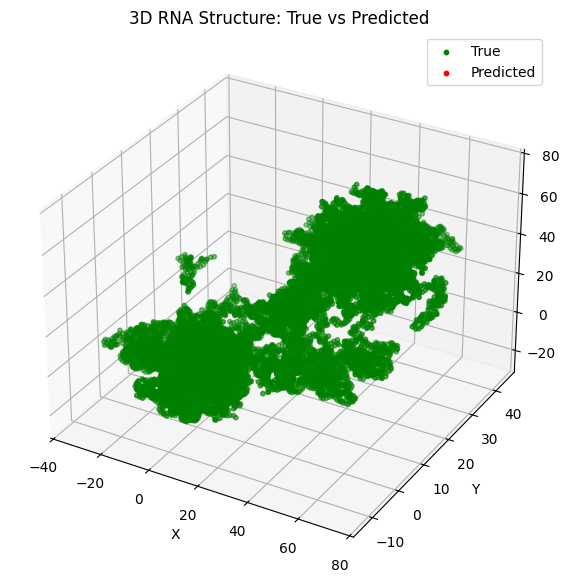

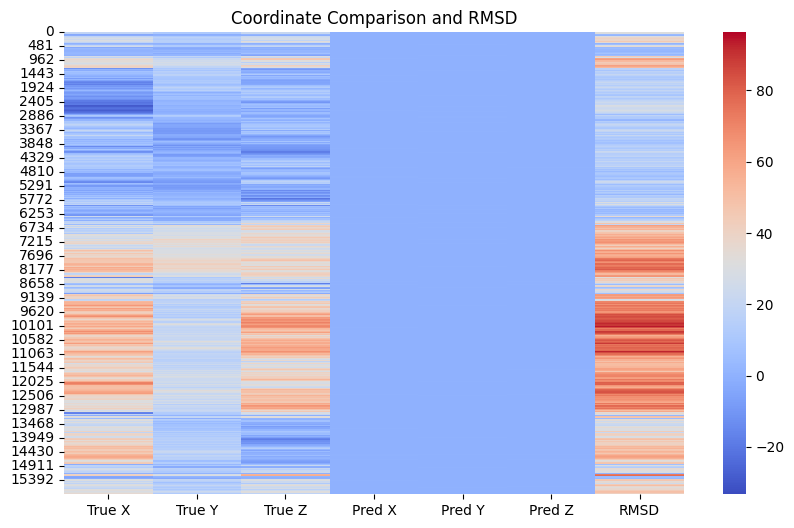

In [9]:
# rna_graphsage_predictor.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# Load and preprocess data
seq_df = pd.read_csv('/kaggle/cleaned_train_sequences2 (1).csv')
label_df = pd.read_csv('/kaggle/train_labels1.csv')

label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')

merged = pd.merge(label_df, seq_df[['target_id', 'sequence']], on='target_id', how='left')
complete_ids = merged.groupby('target_id')['resid'].count()
valid_ids = complete_ids[complete_ids > 10].index
merged = merged[merged['target_id'].isin(valid_ids)]

all_ids = merged['target_id'].unique()
train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph_from_group(df_group, scaler=None, fit_scaler=False):
    df_group = df_group.sort_values('resid')
    coords = df_group[['x_1', 'y_1', 'z_1']].values

    if scaler is not None:
        coords = scaler.fit_transform(coords) if fit_scaler else scaler.transform(coords)

    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]
    pos = torch.tensor(coords, dtype=torch.float)
    y = pos.clone()

    n = len(df_group)
    edge_index = torch.tensor(
        [[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

scaler = StandardScaler()
train_graphs = [create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=True) for tid in tqdm(train_ids)]
val_graphs = [create_graph_from_group(merged[merged['target_id'] == tid], scaler, fit_scaler=False) for tid in tqdm(val_ids)]

train_loader = DataLoader(train_graphs, batch_size=1)
val_loader = DataLoader(val_graphs, batch_size=1)

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(in_channels=4, hidden_channels=32, out_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
loss_fn = nn.MSELoss()

best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

model.train()
for epoch in range(100):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

model.eval()
predictions, true = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        pred_coords = model(batch)
        predictions.append(pred_coords.cpu().numpy())
        true.append(batch.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true = np.concatenate(true, axis=0)

rmse = np.sqrt(mean_squared_error(true, predictions))
mae = mean_absolute_error(true, predictions)

def calculate_tm_score(true, pred):
    d = np.linalg.norm(true - pred, axis=1)
    N = true.shape[0]
    return np.mean(np.exp(-d / (0.5 * N)))

def calculate_rmsd(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

tm_score = calculate_tm_score(true, predictions)
rmsd = calculate_rmsd(true, predictions)

print("\nValidation Metrics:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"TM-Score: {tm_score:.6f}")
print(f"RMSD: {rmsd:.6f}")

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true[:, 0], true[:, 1], true[:, 2], c='g', label='True', s=10)
ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='r', label='Predicted', s=10)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D RNA Structure: True vs Predicted')
ax.legend()
plt.show()

rmsd_errors = np.linalg.norm(true - predictions, axis=1)
matrix = np.vstack([true.T, predictions.T, rmsd_errors]).T
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, cmap='coolwarm', xticklabels=['True X', 'True Y', 'True Z', 'Pred X', 'Pred Y', 'Pred Z', 'RMSD'])
plt.title('Coordinate Comparison and RMSD')
plt.show()


In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Then save it to your drive
torch.save(model.state_dict(), '/content/drive/MyDrive/Graphsage_Model.pth')
joblib.dump(scaler, '/content/drive/MyDrive/Graphsage_Scaler.save')

print("Saved to Google Drive as 'Graphsage_Model.pth'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to Google Drive as 'Graphsage_Model.pth'
